# Emotion Analysis
Author: Junruo Zhu

Date: 13 Oct, 2023

This code perform emotion analysis on the given corpus and returns the emotion values (e.g. ⏰) each text. The datasets applied in this code were preprocessed by the code, Preprocess.ipynb (see: https://colab.research.google.com/drive/1C9p1nz3HsTjC5FmQxv5UUFMFSEuh3jtZ).

 * In acknowledgment of the contributions made, portions of this code were developed with the guidance and assistance of ChatGPT.

## Step 0. Preparation and Have a Quick View of data

In [1]:
# installation
!pip install transformers

In [3]:
# Get all libraries ready
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
from tqdm.notebook import tqdm

import torch
print(torch.cuda.is_available())

True


### Read preprocessed date sets

WoS

In [4]:
# Read
from google.colab import drive
drive.mount("/content/drive")
aca_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Masters_Thesis/0_corpus/preprocessed_for_sentiment_analysis/aca_sentiment_df.csv")


# Get an example text from this corpus
aca_example = aca_df["text"].iloc[0]
print(aca_example)
# Have a look at this dataset
aca_df.head()

Mounted at /content/drive
Changing the World One Meme at a Time: The Effects of Climate Change Memes on Civic Engagement Intentions. The risks that animals and humans face from climate change are frequently featured in climate change memes. Although memes may appear to some as silly jokes, little is known of the impact they may have in the formation and spread of individuals' perceived risk of climate change and intention to participate in climate change campaigns. This study tests the effect of climate change memes on the perceived risk of climate change and the intention of online engagement regarding climate change issues. Results show that exposure to climate change memes increases individual intentions of online civic engagement regarding climate change. Additionally, empathy is found to mediate this effect. However, risk perception of climate change is not altered after exposure to climate change memes.


,id,year,text
0,1,2021,Changing the World One Meme at a Time: The Eff...
1,2,2021,"The Relationship between Social Norms, Avoidan..."
2,3,2013,An Evaluation of Urban Citizens' Awareness of ...
3,4,2021,How and when higher climate change risk percep...
4,5,2022,Climate change impact and adaptation for highw...


Reddit

In [6]:
# Read
red_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Masters_Thesis/0_corpus/preprocessed_for_sentiment_analysis/red_sentiment_df.csv")
# Get an example text from this corpus
red_example = red_df["text"].iloc[0]
print(red_example)
# Have a look at this dataset
red_df.head()

Discussing climate change with a skeptic on another site and they pull this link some kind of trump card. Reading in between the lines, I believe it doesn't mean what they think it means but I must confess I don't know what "forcings" or "polynomial cointegration" mean. Also, I am not familiar enough with Earth System Dynamics to know if they are a reputable organization. If anyone can shed light on this, I would be grateful.


,id,year,text
0,c7w2a9f,2013,Discussing climate change with a skeptic on an...
1,c7x3p76,2013,That hasn't even been considered for several y...
2,c7xjxtf,2013,anything on non- carbon dioxide GHGs? I though...
3,c7xkqi8,2013,That would be easy to find as well since there...
4,c7xp7wy,2013,"Cool, thanks"


## Step 1. Prepare a Roberta Pretrained Model for emotion Analysis
⏰ choose a better model from the following ones:
* https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
* https://huggingface.co/mrm8488/t5-base-finetuned-emotion
* https://huggingface.co/bdotloh/distilbert-base-uncased-empathetic-dialogues-context

I use "Emotion English DistilRoBERTa-base". Original Source: [ https://huggingface.co/j-hartmann/emotion-english-distilroberta-base ]





In [7]:
MODEL = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model = model.to("cuda")  # Move the model to GPU

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [8]:
# Define a function computing the emotion scores of a long text

def analyze_emotion(text: str):
    # Tokenize the input with overflow handling
    encodings = tokenizer(text, return_tensors="pt",
                          return_overflowing_tokens=True,
                          stride=256,
                          truncation=True,
                          padding="longest",
                          max_length=512).to("cuda")  # Move the encodings to GPU
    # Handle each segment and collect scores
    all_scores = []
    emotion_dict = {}
    for i in range(len(encodings["input_ids"])):
        segment = {k: v[i].unsqueeze(0) for k, v in encodings.items()}
        # Remove the argument not needed by the model
        segment.pop("overflow_to_sample_mapping", None)

        output = model(**segment)
        scores = output[0][0].detach().cpu().numpy()
        scores = softmax(scores)
        all_scores.append(scores)

    # Calculate the mean of the scores for all segments
    mean_scores = np.mean(all_scores, axis=0)
    emotion_dict = {
        "anger" : mean_scores[0],
        "disgust" : mean_scores[1],
        "fear" : mean_scores[2],
        "joy" : mean_scores[3],
        "neutral" : mean_scores[4],
        "sadness" : mean_scores[5],
        "surprise" : mean_scores[6],
    }

    return emotion_dict

### To see how this model works on examples:

Example 1: a made-up sentence

In [9]:
# a neutral sentence.
text = "Dogs ran away."
# Tokenize the input with overflow handling
encodings = tokenizer(text, return_tensors="pt", return_overflowing_tokens=True,
                      stride=256, truncation=True, padding="longest", max_length=512)
# See how many segments this model makes on the example
for i, input_ids in enumerate(encodings["input_ids"]):
    segment_text = tokenizer.decode(input_ids)
    print(f"Segment {i + 1}: \"{segment_text}\"")

# Get scores
scores = analyze_emotion(text)
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
print(sorted_scores)

Segment 1: "<s>Dogs ran away.</s>"
{'neutral': 0.37398204, 'fear': 0.24560948, 'sadness': 0.15398432, 'anger': 0.14551264, 'surprise': 0.04884525, 'disgust': 0.025957536, 'joy': 0.0061087264}


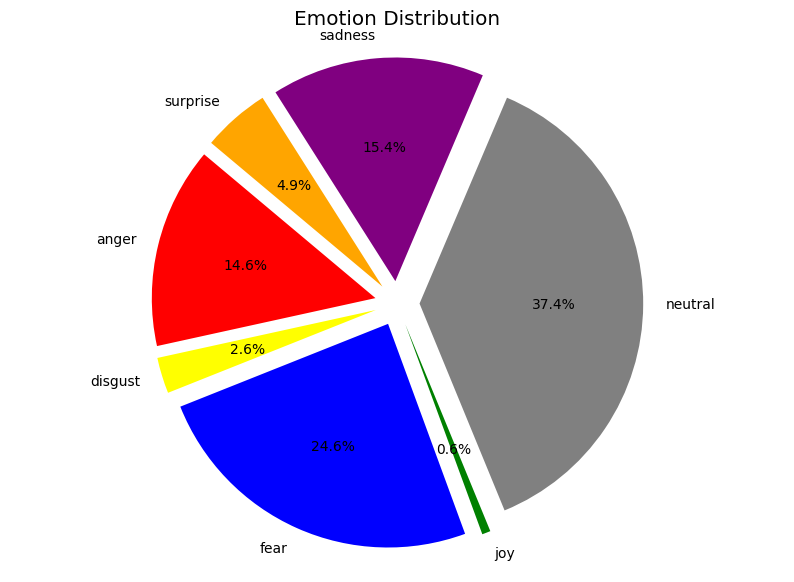

In [10]:
# Plot the emotion pie chart

# Extracting labels and values
labels = list(scores.keys())
sizes = list(scores.values())
colors = ['red', 'yellow', 'blue', 'green', 'grey', 'purple', 'orange']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # To explode the slices for better visibility
# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Emotion Distribution")
plt.show()

Example 2: a sentence from the academic corpus

In [11]:
# our example from the data set
text = aca_example
# Tokenize the input with overflow handling
encodings = tokenizer(text, return_tensors="pt", return_overflowing_tokens=True,
                      stride=256, truncation=True, padding="longest", max_length=512)
# See how many segments this model makes on the example
for i, input_ids in enumerate(encodings["input_ids"]):
    segment_text = tokenizer.decode(input_ids)
    print(f"Segment {i + 1}: \"{segment_text}\"")

# Get scores
scores = analyze_emotion(text)
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
print(sorted_scores)

Segment 1: "<s>Changing the World One Meme at a Time: The Effects of Climate Change Memes on Civic Engagement Intentions. The risks that animals and humans face from climate change are frequently featured in climate change memes. Although memes may appear to some as silly jokes, little is known of the impact they may have in the formation and spread of individuals' perceived risk of climate change and intention to participate in climate change campaigns. This study tests the effect of climate change memes on the perceived risk of climate change and the intention of online engagement regarding climate change issues. Results show that exposure to climate change memes increases individual intentions of online civic engagement regarding climate change. Additionally, empathy is found to mediate this effect. However, risk perception of climate change is not altered after exposure to climate change memes.</s>"
{'neutral': 0.899345, 'fear': 0.033485413, 'surprise': 0.018813152, 'anger': 0.0175

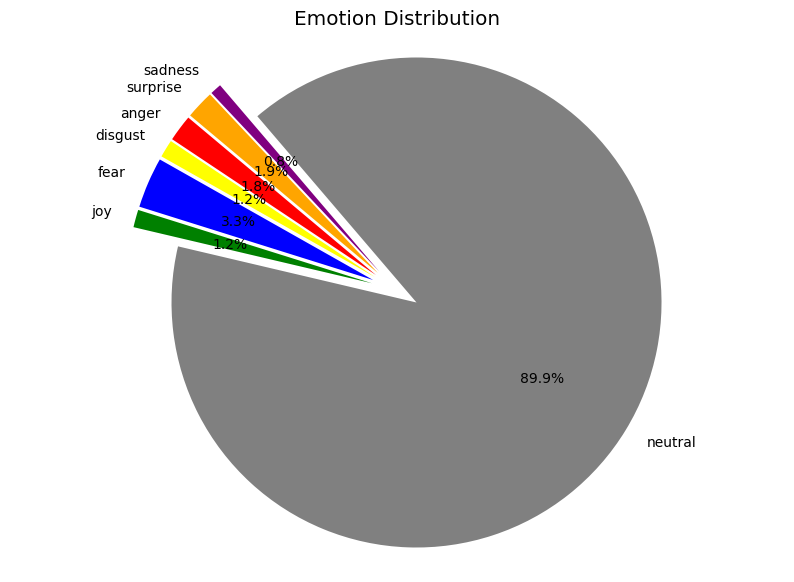

In [12]:
# Plot the emotion pie chart

# Extracting labels and values
labels = list(scores.keys())
sizes = list(scores.values())
colors = ['red', 'yellow', 'blue', 'green', 'grey', 'purple', 'orange']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # To explode the slices for better visibility
# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Emotion Distribution")
plt.show()

## Step 2. Apply this model to the corpus

1.  I defined a main fucntion containing a series of functions first.
2.  I apply a main function to each corpus.


### Define subfunctions and a main function

In [13]:
def apply_function_to_corpus(corpus):
    ''' Produce the emotion scores of each text
    '''
    results = {}
    for i, row in tqdm(corpus.iterrows(), total=len(corpus)):
        try:
            text = str(row["text"])
            myid = row["id"]

            result = analyze_emotion(text)

            results[myid] = result
        except RuntimeError:
            print(f"Broke for id {myid}")
    return results


def save_results_to_a_dataframe(results, corpus):
    ''' Merge the results (emotion scores) with corpus
    '''
    # Make a new dataframe keeping the emotion values
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={"index": "id"})
    # Create a new dataframe merging results_df with df
    results_df = results_df.merge(corpus, how="left")

    return results_df


def save_results_to_drive(results_df, save_path):
    """
    Save the DataFrame with emotion scores for each text to a file.
    """
    results_df.to_csv(save_path, index=False)
    print(f"Dataframe saved to {save_path}")


def get_mean_of_emotion(results_df):
    ''' Compute the average of each emotion across years
    '''
    yearly_avg = results_df.groupby('year')[['anger',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'neutral',
                                             'sadness',
                                             'surprise'
                                             ]].mean().reset_index()

    return yearly_avg


def save_means_to_drive(yearly_avg, save_path):
    '''
    '''
    yearly_avg.to_csv(save_path, index=False)
    print(f"Dataframe saved to {save_path}")


def main(corpus, corpus_name):
    results = apply_function_to_corpus(corpus)
    merged_df = save_results_to_a_dataframe(results, corpus)
    yearly_avg = get_mean_of_emotion(merged_df)

    # Save the merged DataFrame with emotion values
    file_path = f"/content/{corpus_name}_emotion_full.csv"
    save_results_to_drive(merged_df, file_path)

    # Save the yearly averages
    yearly_avg_path = f"/content/{corpus_name}_emotion_yearly_avg.csv"
    save_results_to_drive(yearly_avg, yearly_avg_path)

    return merged_df, yearly_avg

### Apply to the academic corpus

In [14]:
# Apply the function
aca_results_df, aca_yearly_avg = main(aca_df, "aca")


  0%|          | 0/14519 [00:00<?, ?it/s]

Dataframe saved to /content/aca_emotion_full.csv
Dataframe saved to /content/aca_emotion_yearly_avg.csv


In [15]:
# check the result
print('Show the first 5 rows of the dataFrame with emotion value for each text:')
aca_results_df.head()

Show the first 5 rows of the dataFrame with emotion value for each text:


,id,anger,disgust,fear,joy,neutral,sadness,surprise,year,text
0,1,0.017555,0.011695,0.033485,0.011583,0.899345,0.007523,0.018813,2021,Changing the World One Meme at a Time: The Eff...
1,2,0.009957,0.029650,0.011401,0.010008,0.926780,0.006013,0.006191,2021,"The Relationship between Social Norms, Avoidan..."
2,3,0.016779,0.025357,0.018120,0.016827,0.890255,0.015119,0.017543,2013,An Evaluation of Urban Citizens' Awareness of ...
3,4,0.016329,0.015477,0.009703,0.005500,0.935995,0.009869,0.007126,2021,How and when higher climate change risk percep...
4,5,0.014415,0.009231,0.043595,0.012774,0.878208,0.014290,0.027486,2022,Climate change impact and adaptation for highw...


In [16]:
print('See the frist 10 rows of the means of each emotion value in every year')
aca_yearly_avg.head(10)

See the frist 10 rows of the means of each emotion value in every year


,year,anger,disgust,fear,joy,neutral,sadness,surprise
0,2013,0.030619,0.034204,0.092750,0.010406,0.793893,0.019174,0.018954
1,2014,0.031537,0.034785,0.095016,0.011726,0.790928,0.017946,0.018063
2,2015,0.028927,0.035250,0.085447,0.012044,0.803736,0.016967,0.017628
3,2016,0.031714,0.036791,0.090964,0.011889,0.792724,0.019062,0.016856
4,2017,0.032628,0.038383,0.089894,0.012857,0.788975,0.019774,0.017489
5,2018,0.028748,0.034707,0.094732,0.011386,0.794027,0.017630,0.018771
6,2019,0.032445,0.037243,0.092471,0.013662,0.787926,0.018072,0.018181
7,2020,0.036053,0.037146,0.104606,0.011316,0.772490,0.020752,0.017637
8,2021,0.030875,0.037626,0.096258,0.011537,0.786574,0.018687,0.018444
9,2022,0.034373,0.037823,0.103090,0.012639,0.773995,0.020444,0.017637


### Apply to the Reddit corpus


In [17]:
# Apply the function
red_results_df, red_yearly_avg = main(red_df, "red")

  0%|          | 0/153825 [00:00<?, ?it/s]

Dataframe saved to /content/red_emotion_full.csv
Dataframe saved to /content/red_emotion_yearly_avg.csv


In [18]:
# check the result
print('Show the first 5 rows of the dataFrame with emotion value for each text:')
red_results_df.head()

Show the first 5 rows of the dataFrame with emotion value for each text:


,id,anger,disgust,fear,joy,neutral,sadness,surprise,year,text
0,c7w2a9f,0.016242,0.017509,0.001426,0.005566,0.939754,0.006257,0.013246,2013,Discussing climate change with a skeptic on an...
1,c7x3p76,0.013819,0.016573,0.001872,0.002250,0.909054,0.006600,0.049833,2013,That hasn't even been considered for several y...
2,c7xjxtf,0.048782,0.140758,0.007932,0.003753,0.546801,0.023632,0.228342,2013,anything on non- carbon dioxide GHGs? I though...
3,c7xkqi8,0.023318,0.162132,0.004008,0.005939,0.789204,0.009807,0.005591,2013,That would be easy to find as well since there...
4,c7xp7wy,0.006860,0.008868,0.000954,0.638695,0.326775,0.004980,0.012869,2013,"Cool, thanks"


In [19]:
print('See the frist 10 rows of the means of each emotion value in every year')
red_yearly_avg.head(10)

See the frist 10 rows of the means of each emotion value in every year


,year,anger,disgust,fear,joy,neutral,sadness,surprise
0,2013,0.102825,0.099325,0.058100,0.063117,0.512138,0.047914,0.116580
1,2014,0.087711,0.115822,0.049939,0.058833,0.553679,0.045242,0.088773
2,2015,0.121693,0.123834,0.039460,0.032637,0.535093,0.039751,0.107532
3,2016,0.085512,0.098587,0.061986,0.042329,0.578939,0.035469,0.097179
4,2017,0.095543,0.108130,0.052002,0.039508,0.560295,0.044522,0.099999
5,2018,0.085427,0.100782,0.064186,0.041548,0.571460,0.046574,0.090022
6,2019,0.088051,0.103726,0.065883,0.042653,0.560737,0.045413,0.093537
7,2020,0.087969,0.104208,0.056418,0.042408,0.561975,0.042741,0.104282
8,2021,0.087334,0.103314,0.058185,0.046673,0.559370,0.050047,0.095076
9,2022,0.081181,0.100034,0.052047,0.042456,0.583836,0.046467,0.093980


## Step 3. Plot Results


### Define a plot function


In [20]:
def plot(yearly_avg):
    '''
    '''
    # Colorblind-friendly colors
    colors = {
        'anger': '#e41a1c',    # red
        'disgust': '#377eb8',  # blue
        'fear': '#4daf4a',     # green
        'joy': '#984ea3',      # purple
        'neutral': '#ff7f00',  # orange
        'sadness': '#ffff33',  # yellow
        'surprise': '#a65628'  # brown
    }

    # Plot content
    plt.figure(figsize=(12,7))

    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

    for emotion in emotions:
        # Filling between the line plot and x-axis
        plt.fill_between(yearly_avg['year'], yearly_avg[emotion], alpha=0.2, label=f'{emotion.capitalize()} Emotion', color=colors[emotion])
        # Drawing the line plots
        plt.plot(yearly_avg['year'], yearly_avg[emotion], color=colors[emotion], marker='o')
        # Annotating the values on the plot
        for i, row in yearly_avg.iterrows():
            plt.annotate(f"{row[emotion]:.2f}", (row['year'], row[emotion]), ha='center', va='bottom', color=colors[emotion])

    plt.title('Yearly Average Emotion Values')
    plt.xlabel('Year')
    plt.ylabel('Average Emotion Value')
    plt.legend()
    plt.grid(True)

    # Setting x-axis to show each year
    plt.xticks(yearly_avg["year"])

    plt.tight_layout()

    # Show the plot
    plt.show()

### Apply to the academic corpus

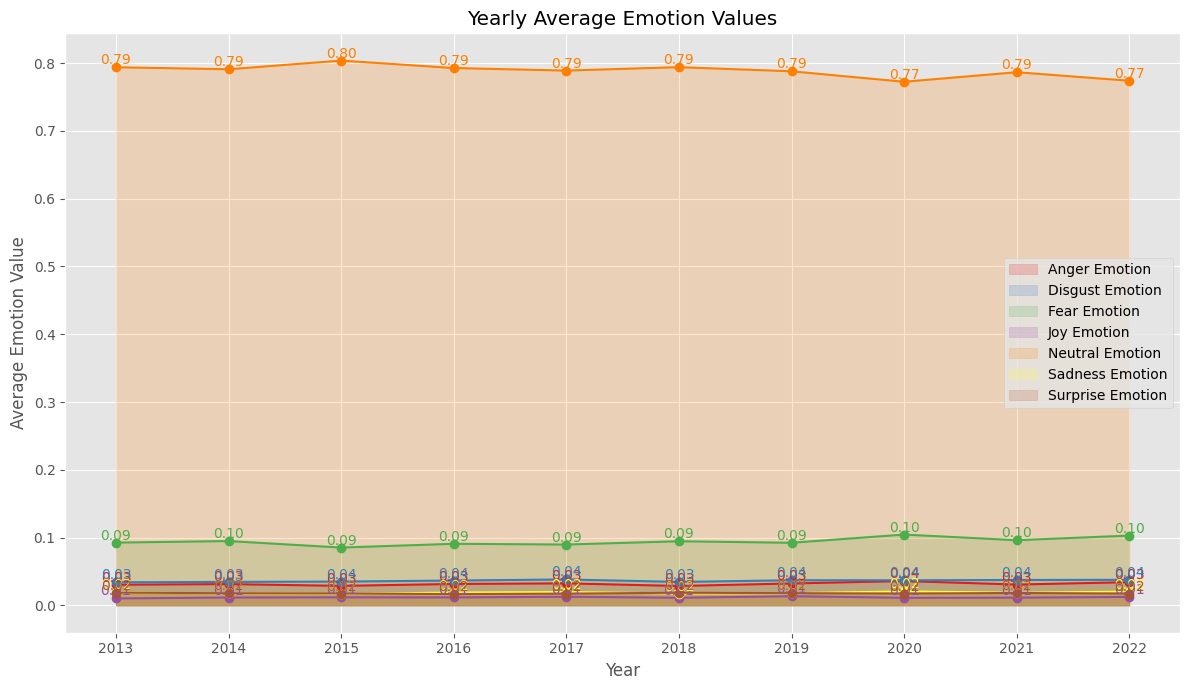

In [21]:
plot(aca_yearly_avg)

### Apply to the Reddit Corpus

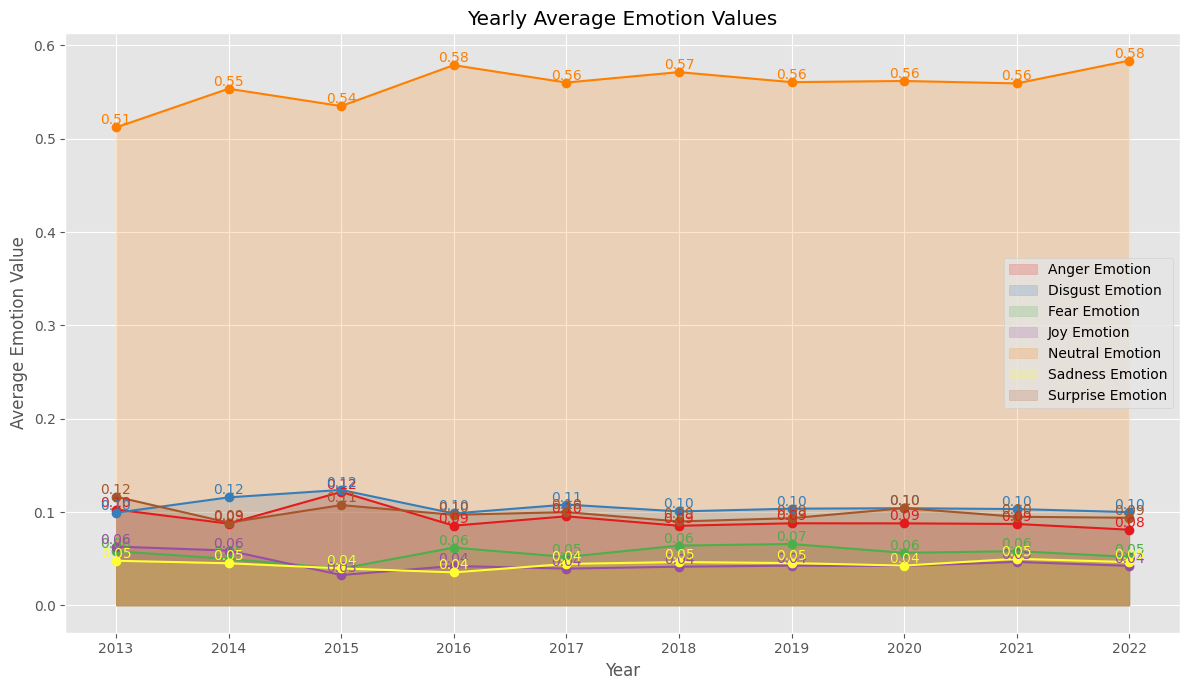

In [22]:
plot(red_yearly_avg)